In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob, inspect, sys, pickle

import xgboost as xgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.inspection import permutation_importance

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_2' from '/home/marie-anne/code/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

### Import df and train test split

In [23]:
X_train_ori, X_test_ori, y_train_ori, y_test_ori = mc.load_data(os.path.join(os.path.dirname(os.getcwd()),'../Data/Merged_data/CopulaGAN_simulated_data_up.csv'),
                                               MinMaxScaler())

In [10]:
# get feature names
feature_names=list(X_train_ori)

### Dummy regressor on all steel

In [11]:
# Evaluate naive

naive = DummyRegressor(strategy='median')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(naive, X_train_ori, y_train_ori, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('Baseline: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Baseline: -31.521 (3.286)


### GridSearch CV

In [12]:
# Create model_dict

model_GSCV = dict()

model_GSCV['Elastic'] = ElasticNet()
model_GSCV['Tree'] = DecisionTreeRegressor()
model_GSCV['KNN'] = KNeighborsRegressor()
model_GSCV['SVM'] = SVR()
model_GSCV['RF'] = RandomForestRegressor()
model_GSCV['XGB'] = xgb.XGBRegressor(objective= 'reg:squarederror',
                        eval_metric = 'rmse',
                        learning_rate = 0.01, 
                        nthread=4,
                        seed=42)


In [13]:
# Define best_model:
def best_model(X_train, y_train, steel, name, model):
    '''run standard scaler and gridsearch CV pipeline on models
    Args:
        -model: initiated model 
        -name : name of model as str
    return list of best estimator and table of results
    '''
    X_train = X_train[X_train.index.str.contains(steel)]
    y_train= y_train[y_train.index.str.contains(steel)]

    
    best_model_stack = list()
    results_cv = dict()
    
    def grid_csv(params):
        
        GSCV = GridSearchCV(model, param_grid = params, scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2', 'neg_root_mean_squared_error'], 
                            refit='neg_root_mean_squared_error', 
                            cv = 10, n_jobs=-1, verbose=True)
        best_clf = GSCV.fit(X_train, y_train)
        best_hyperparams = best_clf.best_params_
        best_score = best_clf.best_score_
        estimator = best_clf.best_estimator_
        print(best_score, best_hyperparams, estimator)
        table = best_clf.cv_results_
        results_cv[name] = table
        return estimator
    
    if name == 'Elastic':
        params = {'l1_ratio' : [0, 0.25, 0.5, 1], 
                  'alpha' : [0, 0.5, 1, 2]} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'Tree':
        params = {'max_features' : ['auto', 'sqrt', 'log2'],
                  'criterion' : ['mse', 'friedman_mse', 'mae'],
                  'max_depth' : np.arange(5, 15, 1)}
        best_model_stack.append(grid_csv(params))
        
    if name == 'KNN':
        params = {'n_neighbors' : np.arange(5, 25, 5),
                 'weights' : ['uniform', 'distance'],
                 'algorithm' : ['ball_tree', 'kd_tree', 'brute', 'auto']} 
        best_model_stack.append(grid_csv(params))
    
    if name == 'SVM':
        params = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                 'C' : [0.2, 0.5, 1]} 
        best_model_stack.append(grid_csv(params))


    if name == 'RF': 
        params = {'n_estimators' : np.arange(100, 200, 50),
                  'max_features' : ['auto', 'sqrt', 'log2'],
                  'criterion' : ['mse', 'mae'],
                  'max_depth' : np.arange(5, 15, 1),
                 } 
        best_model_stack.append(grid_csv(params))
    
    if name == 'XGB':
        params = {'n_estimators' : np.arange(500, 2000, 250),
                  'gamma': np.arange(0.1, 1, 0.5),
                  'reg_lambda':[1e-8,  1e-4],
                  'max_depth' : np.arange(5, 15, 2),
                 } 
        best_model_stack.append(grid_csv(params))

        
    return best_model_stack, results_cv

In [14]:
all_results=dict()
for steel in set(X_train_ori.index.str.split('-').str[0]):
    print(steel)
    results_best_model = list()
    scoring = dict()
    for name, model in model_GSCV.items():

        scores = best_model(X_train_ori, y_train_ori, steel, name, model)
        results_best_model.append(scores[0][0])
        scoring[name] = pd.DataFrame(scores[1][name])

    #save params
    with pd.ExcelWriter(os.path.join(os.getcwd(), 'Results_CV/' + steel + '_result_CV.xlsx')) as writer:
        for df_name, df in scoring.items():
            df.to_excel(writer, sheet_name=df_name) 
    all_results[steel] = results_best_model
    with open('Results_CV/all_results_CV.p', 'wb') as fp:
        pickle.dump(all_results, fp, protocol=pickle.HIGHEST_PROTOCOL)


347
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.3s finished
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18337.353866909798, tolerance: 50.55853344101947
  model =

-14.086972157956748 {'alpha': 0, 'l1_ratio': 0} ElasticNet(alpha=0, l1_ratio=0)
Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-13.295957844159307 {'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'auto'} DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                      max_features='auto')
Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-11.316356728136395 {'algorithm': 'ball_tree', 'n_neighbors': 20, 'weights': 'distance'} KNeighborsRegressor(algorithm='ball_tree', n_neighbors=20, weights='distance')
Fitting 10 folds for each of 12 candidates, totalling 120 fits
-13.570290396710439 {'C': 1, 'kernel': 'poly'} SVR(C=1, kernel='poly')
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.2min finished


-11.431789747349617 {'criterion': 'mse', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 100} RandomForestRegressor(max_depth=13)
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 26.1min finished


-11.890751960606803 {'gamma': 0.6, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 1e-08} XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0.6, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
             num_parallel_tree=1, random_state=42, reg_alpha=0,
             reg_lambda=1e-08, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
A286
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.3s finished
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26168.512488267173, tolerance: 51.521937938185204
  model 

-17.699994997113937 {'alpha': 0, 'l1_ratio': 0} ElasticNet(alpha=0, l1_ratio=0)
Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-10.809534358392112 {'criterion': 'mse', 'max_depth': 5, 'max_features': 'log2'} DecisionTreeRegressor(max_depth=5, max_features='log2')
Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


-9.479833220192981 {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'} KNeighborsRegressor(algorithm='ball_tree', n_neighbors=10, weights='distance')
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-20.73013619407281 {'C': 1, 'kernel': 'poly'} SVR(C=1, kernel='poly')
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.4min finished


-10.037547172261272 {'criterion': 'mae', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 150} RandomForestRegressor(criterion='mae', max_depth=7, max_features='log2',
                      n_estimators=150)
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 25.5min finished


-12.038455213037233 {'gamma': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 1e-08} XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0.1, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
             num_parallel_tree=1, random_state=42, reg_alpha=0,
             reg_lambda=1e-08, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
316
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.3s finished
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15778.808030866963, tolerance: 10.391784368933124
  model 

-12.317493637280078 {'alpha': 0, 'l1_ratio': 0} ElasticNet(alpha=0, l1_ratio=0)
Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-13.889987268777949 {'criterion': 'friedman_mse', 'max_depth': 14, 'max_features': 'sqrt'} DecisionTreeRegressor(criterion='friedman_mse', max_depth=14,
                      max_features='sqrt')
Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


-11.245582698112441 {'algorithm': 'brute', 'n_neighbors': 20, 'weights': 'distance'} KNeighborsRegressor(algorithm='brute', n_neighbors=20, weights='distance')
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-14.083102585427747 {'C': 1, 'kernel': 'poly'} SVR(C=1, kernel='poly')
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.5min finished


-10.799499923747645 {'criterion': 'mae', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100} RandomForestRegressor(criterion='mae', max_depth=10, max_features='log2')
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 26.5min finished


-12.12131444854483 {'gamma': 0.1, 'max_depth': 5, 'n_estimators': 500, 'reg_lambda': 1e-08} XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0.1, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
             num_parallel_tree=1, random_state=42, reg_alpha=0,
             reg_lambda=1e-08, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
304
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.3s finished
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20969.146105017968, tolerance: 20.315789887629375
  model 

-14.518326266363932 {'alpha': 0, 'l1_ratio': 0} ElasticNet(alpha=0, l1_ratio=0)
Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


-16.084117112773264 {'criterion': 'friedman_mse', 'max_depth': 5, 'max_features': 'sqrt'} DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                      max_features='sqrt')
Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s


-14.380442475321138 {'algorithm': 'ball_tree', 'n_neighbors': 15, 'weights': 'distance'} KNeighborsRegressor(algorithm='ball_tree', n_neighbors=15, weights='distance')
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-14.552211719526671 {'C': 0.5, 'kernel': 'poly'} SVR(C=0.5, kernel='poly')
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


-14.01264500989426 {'criterion': 'mae', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100} RandomForestRegressor(criterion='mae', max_depth=5, max_features='log2')
Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 28.2min finished


-15.899928327620742 {'gamma': 0.6, 'max_depth': 5, 'n_estimators': 750, 'reg_lambda': 0.0001} XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0.6, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=750, n_jobs=4, nthread=4,
             num_parallel_tree=1, random_state=42, reg_alpha=0,
             reg_lambda=0.0001, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


## Regression

In [16]:
with open('Results_CV/all_results_CV.p', 'rb') as fp:
    dict_results = pickle.load(fp)
    print(dict_results)

{'347': [ElasticNet(alpha=0, l1_ratio=0), DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                      max_features='auto'), KNeighborsRegressor(algorithm='ball_tree', n_neighbors=20, weights='distance'), SVR(C=1, kernel='poly'), RandomForestRegressor(max_depth=13), XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0.6, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
             num_parallel_tree=1, random_state=42, reg_alpha=0,
             reg_lambda=1e-08, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)], 'A286': [ElasticNet(alpha=0, l1_ratio=0), DecisionTreeRegressor(max_depth=5, max_f

In [20]:
def train_model(X_train, y_train, X_test, y_test, steel, name, model):
    predictions = pd.DataFrame()
    X_train = X_train[X_train.index.str.contains(steel)]
    y_train = y_train[y_train.index.str.contains(steel)]
    X_test = X_test[X_test.index.str.contains(steel)]
    y_test = y_test[y_test.index.str.contains(steel)]

    
    if name == 'XGB':
        X_train_df= pd.DataFrame(X_train, columns=feature_names)
        reg = model.fit(X_train_df, y_train)

    else:
        reg = model.fit(X_train, y_train)
        
    y_pred = reg.predict(X_test)
    print(y_test.shape, y_pred.shape)
    
    
    print("r2 score for training: ", r2_score(y_train, reg.predict(X_train)))
    print("r2 score for testing: ", r2_score(y_test, y_pred))
    
    print("RMSE score for training: ", np.sqrt(mean_squared_error(y_train, reg.predict(X_train))))
    print("RMSE score for testing: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([0, 250], [0, 250])
    plt.xlim([0, 250])
    plt.ylim([0, 250])
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    plt.title(steel + ', ' + name)
    plt.show()
    
    return reg

(58,) (58,)
r2 score for training:  0.9274608948524914
r2 score for testing:  0.9115575123905931
RMSE score for training:  13.507821160593005
RMSE score for testing:  12.402289665559302


<ipython-input-20-a49c4dd60d60>:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = model.fit(X_train, y_train)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18337.353866909798, tolerance: 50.55853344101947
  model = cd_fast.enet_coordinate_descent(


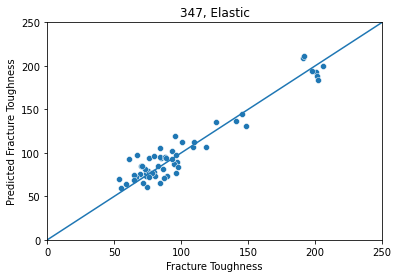

ElasticNet(alpha=0, l1_ratio=0)
(58,) (58,)
r2 score for training:  0.9745657075077773
r2 score for testing:  0.8969586453610516
RMSE score for training:  7.998508964025591
RMSE score for testing:  13.386812343513602


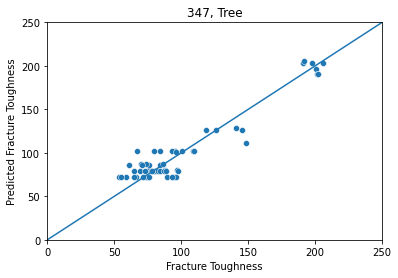

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                      max_features='auto')
(58,) (58,)
r2 score for training:  1.0
r2 score for testing:  0.9312943148525363
RMSE score for training:  0.0
RMSE score for testing:  10.931197301969997


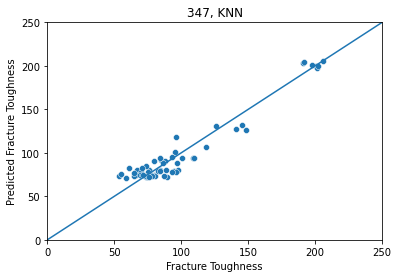

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=20, weights='distance')
(58,) (58,)
r2 score for training:  0.930397586168002
r2 score for testing:  0.8910514428918543
RMSE score for training:  13.231569303520565
RMSE score for testing:  13.765187682110845


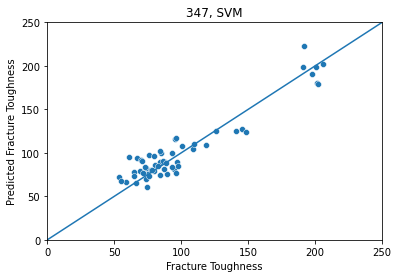

SVR(C=1, kernel='poly')
(58,) (58,)
r2 score for training:  0.9922939103110829
r2 score for testing:  0.9138938203347781
RMSE score for training:  4.402671018975149
RMSE score for testing:  12.237383102102797


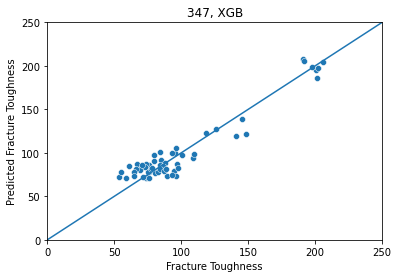

RandomForestRegressor(max_depth=13)
(41,) (41,)
r2 score for training:  0.8984179806292865
r2 score for testing:  0.90818530456517
RMSE score for training:  17.195621729006675
RMSE score for testing:  18.284312928690493


<ipython-input-20-a49c4dd60d60>:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = model.fit(X_train, y_train)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26168.512488267173, tolerance: 51.521937938185204
  model = cd_fast.enet_coordinate_descent(


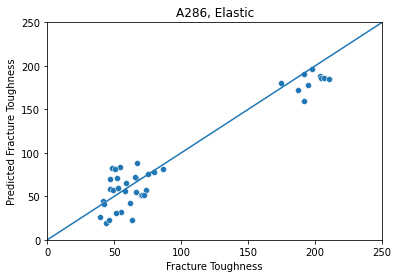

ElasticNet(alpha=0, l1_ratio=0)
(41,) (41,)
r2 score for training:  0.9822499471316548
r2 score for testing:  0.9650602474251088
RMSE score for training:  7.188020174377193
RMSE score for testing:  11.279308081989798


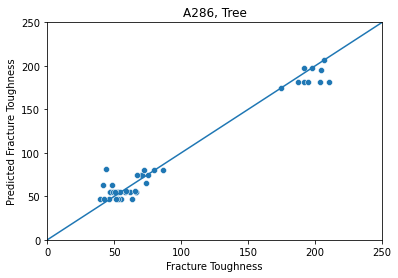

DecisionTreeRegressor(max_depth=5, max_features='log2')
(41,) (41,)
r2 score for training:  1.0
r2 score for testing:  0.976136748827435
RMSE score for training:  0.0
RMSE score for testing:  9.321533242777127


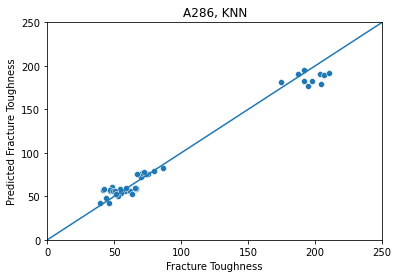

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=10, weights='distance')
(41,) (41,)
r2 score for training:  0.8641440730454769
r2 score for testing:  0.867176821449905
RMSE score for training:  19.886060525533278
RMSE score for testing:  21.991734360101727


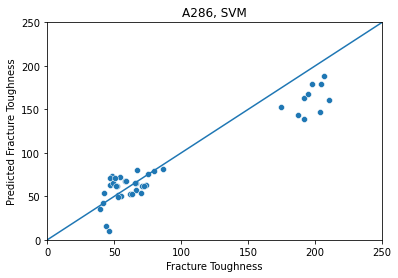

SVR(C=1, kernel='poly')
(41,) (41,)
r2 score for training:  0.9905664455150301
r2 score for testing:  0.974755708563377
RMSE score for training:  5.240191314439474
RMSE score for testing:  9.587472674143141


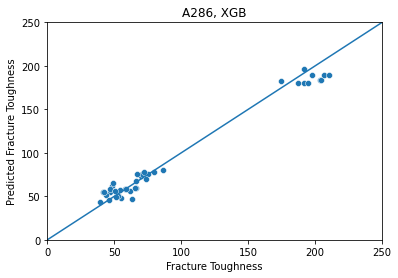

RandomForestRegressor(criterion='mae', max_depth=7, max_features='log2',
                      n_estimators=150)
(53,) (53,)
r2 score for training:  0.6963214887707116
r2 score for testing:  0.6737700444211869
RMSE score for training:  12.200683568410467
RMSE score for testing:  14.183352207079382


<ipython-input-20-a49c4dd60d60>:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = model.fit(X_train, y_train)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15778.808030866963, tolerance: 10.391784368933124
  model = cd_fast.enet_coordinate_descent(


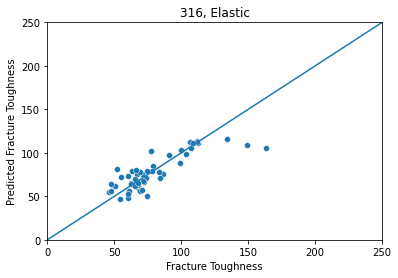

ElasticNet(alpha=0, l1_ratio=0)
(53,) (53,)
r2 score for training:  1.0
r2 score for testing:  0.4821543090759042
RMSE score for training:  0.0
RMSE score for testing:  17.869695513489866


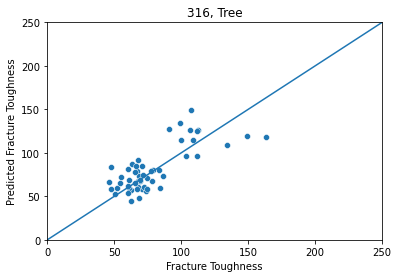

DecisionTreeRegressor(criterion='friedman_mse', max_depth=14,
                      max_features='sqrt')
(53,) (53,)
r2 score for training:  0.9999999999998636
r2 score for testing:  0.7252480861314002
RMSE score for training:  8.178994416603298e-06
RMSE score for testing:  13.016293484619467


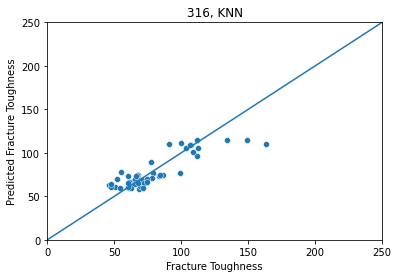

KNeighborsRegressor(algorithm='brute', n_neighbors=20, weights='distance')
(53,) (53,)
r2 score for training:  0.6215415293539392
r2 score for testing:  0.6005640887935363
RMSE score for training:  13.62028665151152
RMSE score for testing:  15.694248427021742


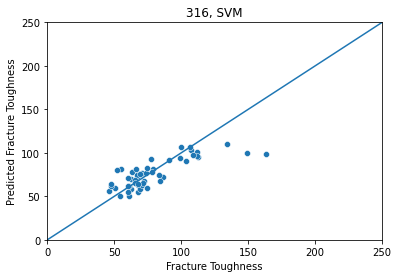

SVR(C=1, kernel='poly')
(53,) (53,)
r2 score for training:  0.9478390192318865
r2 score for testing:  0.7537499865363082
RMSE score for training:  5.056499948293264
RMSE score for testing:  12.322678010397428


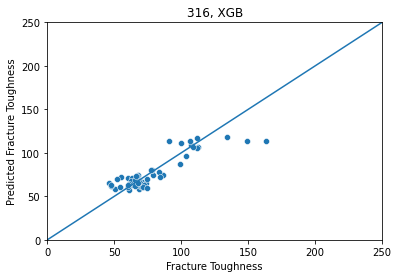

RandomForestRegressor(criterion='mae', max_depth=10, max_features='log2')
(48,) (48,)
r2 score for training:  0.7935679959184216
r2 score for testing:  0.7299337459904318
RMSE score for training:  14.131742758100415
RMSE score for testing:  13.02472756305527


<ipython-input-20-a49c4dd60d60>:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg = model.fit(X_train, y_train)
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/marie-anne/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20969.146105017968, tolerance: 20.315789887629375
  model = cd_fast.enet_coordinate_descent(


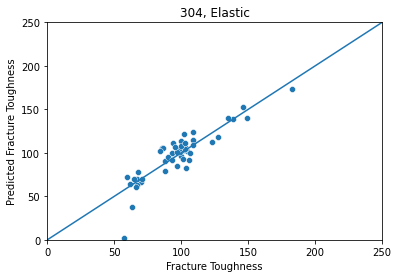

ElasticNet(alpha=0, l1_ratio=0)
(48,) (48,)
r2 score for training:  0.8807174370572661
r2 score for testing:  0.6302064251376256
RMSE score for training:  10.742260749028548
RMSE score for testing:  15.24098965260175


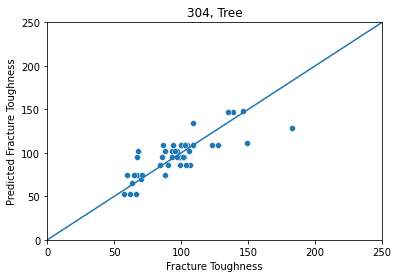

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
                      max_features='sqrt')
(48,) (48,)
r2 score for training:  1.0
r2 score for testing:  0.8247603482282762
RMSE score for training:  0.0
RMSE score for testing:  10.491792153335714


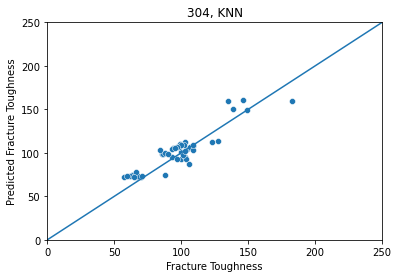

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=15, weights='distance')
(48,) (48,)
r2 score for training:  0.785372739976394
r2 score for testing:  0.7727184593611689
RMSE score for training:  14.409524493653453
RMSE score for testing:  11.948560035033752


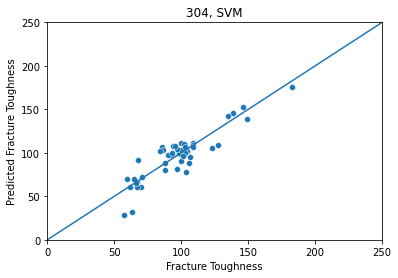

SVR(C=0.5, kernel='poly')
(48,) (48,)
r2 score for training:  0.8974607663994043
r2 score for testing:  0.7959834692189537
RMSE score for training:  9.959837264563275
RMSE score for testing:  11.320514539923957


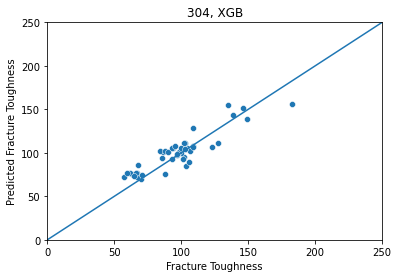

RandomForestRegressor(criterion='mae', max_depth=5, max_features='log2')


In [25]:
model_names = ['Elastic', 'Tree', 'KNN', 'SVM', 'XGB']
for steel in set(X_train_ori.index.str.split('-').str[0]):
    
    # Create model_dict
    list_results = dict_results[steel]
    models = dict(zip(model_names, list_results))
    
    # Fit models
    regressors = dict()
    for name, model in models.items():
        regressors[name] = train_model(X_train_ori, y_train_ori, X_test_ori, y_test_ori, steel, name, model)
        print(regressors[name])